In [1]:
import scipy.io as sio
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pylops.utils.wavelets import ricker
import pylops

from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import r2_score

import tensorflow as tf

from PIL import *

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras import backend as keras

from scipy.signal import filtfilt

from sklearn.model_selection import train_test_split

from matplotlib.backends.backend_pdf import PdfPages

from sklearn import preprocessing
import warnings
warnings.filterwarnings('ignore')

### 加载地震数据和模型数据

In [2]:
syn = sio.loadmat('newsyn.mat')
syn = syn['foo']
Model3 = sio.loadmat('newModel.mat')
Model3 = Model3['foo']

In [3]:
Seis10_0 = syn[:,25,0]
Seis10_1 = syn[:,25+50,0]
Seis10_2 = syn[:,25+50*2,0]

Seis20_0 = syn[:,25,1]
Seis20_1 = syn[:,25+50,1]
Seis20_2 = syn[:,25+50*2,1]

Seis30_0 = syn[:,25,2]
Seis30_1 = syn[:,25+50,2]
Seis30_2 = syn[:,25+50*2,2]

In [4]:
PBYSVP0 =  Model3[:,25,0]
PBYSVP1 =  Model3[:,25+50,0]
PBYSVP2 =  Model3[:,25+50*2,0]

PBYSVS0 =  Model3[:,25,1]
PBYSVS1 =  Model3[:,25+50,1]
PBYSVS2 =  Model3[:,25+50*2,1]

PBYSDN0 =  Model3[:,25,2]
PBYSDN1 =  Model3[:,25+50,2]
PBYSDN2 =  Model3[:,25+50*2,2]

In [5]:
def minmax(data,Min,Max):
    sample = (data - Min)/ (Max - Min)
    return sample 

In [6]:
num = 125
S10min125 = np.min(syn[:,num,0])
S10max125 = np.max(syn[:,num,0])

S20min125 = np.min(syn[:,num,1])
S20max125 = np.max(syn[:,num,1])

S30min125 = np.min(syn[:,num,2])
S30max125 = np.max(syn[:,num,2])

VPmin125 = np.min(Model3[:,num,0])
VPmax125 = np.max(Model3[:,num,0])

VSmin125 = np.min(Model3[:,num,1])
VSmax125 = np.max(Model3[:,num,1])

DNmin125 = np.min(Model3[:,num,2])
DNmax125 = np.max(Model3[:,num,2])

In [7]:
s10_0 = minmax(Seis10_0,S10min125,S10max125)
s10_1 = minmax(Seis10_1,S10min125,S10max125)
s10_2 = minmax(Seis10_2,S10min125,S10max125)

s20_0 = minmax(Seis20_0,S20min125,S20max125)
s20_1 = minmax(Seis20_1,S20min125,S20max125)
s20_2 = minmax(Seis20_2,S20min125,S20max125)

s30_0 = minmax(Seis30_0,S30min125,S30max125)
s30_1 = minmax(Seis30_1,S30min125,S30max125)
s30_2 = minmax(Seis30_2,S30min125,S30max125)

vp = minmax(PBYSVP0,VPmin125,VPmax125)
vp1 = minmax(PBYSVP1,VPmin125,VPmax125)
vp2 = minmax(PBYSVP2,VPmin125,VPmax125)

vs = minmax(PBYSVS0,VSmin125,VSmax125)
vs1 = minmax(PBYSVS1,VSmin125,VSmax125)
vs2 = minmax(PBYSVS2,VSmin125,VSmax125)

dn = minmax(PBYSDN0,DNmin125,DNmax125)
dn1 = minmax(PBYSDN1,DNmin125,DNmax125)
dn2 = minmax(PBYSDN2,DNmin125,DNmax125)

In [8]:
#归一化之后的2道训练样本(地震数据）和标签（模型数据）
x10_train = np.stack((s10_1,s10_2),axis = 0)
x20_train = np.stack((s20_1,s20_2),axis = 0)
x30_train = np.stack((s30_1,s30_2),axis = 0)
x_train = np.stack((x10_train,x20_train,x30_train),axis=2)
x1_train= np.expand_dims(x_train,2)


Y_train0 = np.stack((vp1,vp2),axis = 0)
Y_train1 = np.stack((vs1,vs2),axis = 0)
Y_train2 = np.stack((dn1,dn2),axis = 0)
Y_train = np.stack((Y_train0,Y_train1,Y_train2),axis=2)
Y1_train= np.expand_dims(Y_train,2)

In [9]:
#归一化之后的全部训练样本(地震数据）
S10_0= np.tile(s10_0, (50, 1)).T  # 按列堆叠50次，并将结果转置得到二维数组
S10_1= np.tile(s10_1, (50, 1)).T
S10_2= np.tile(s10_2, (50, 1)).T
S10 = np.concatenate((S10_0,S10_1,S10_2),axis=1)

S20_0= np.tile(s20_0, (50, 1)).T  # 按列堆叠50次，并将结果转置得到二维数组
S20_1= np.tile(s20_1, (50, 1)).T
S20_2= np.tile(s20_2, (50, 1)).T
S20 = np.concatenate((S20_0,S20_1,S20_2),axis=1)

S30_0= np.tile(s30_0, (50, 1)).T  # 按列堆叠50次，并将结果转置得到二维数组
S30_1= np.tile(s30_1, (50, 1)).T
S30_2= np.tile(s30_2, (50, 1)).T
S30 = np.concatenate((S30_0,S30_1,S30_2),axis=1)

S = np.stack((S10,S20,S30),axis=2)
S_= np.expand_dims(S,2)
S2_ = np.transpose(S_,(1,0,2,3))

In [10]:
#取原始地震数据后两个相带各一道地震道
trueseis75 = syn[:,75,:]
trueseis125 = syn[:,125,:]
trueseis2 = np.stack((trueseis75,trueseis125),axis = 0)
trueseis_2 = np.expand_dims(trueseis2,axis = 2)

### 相控约束反演

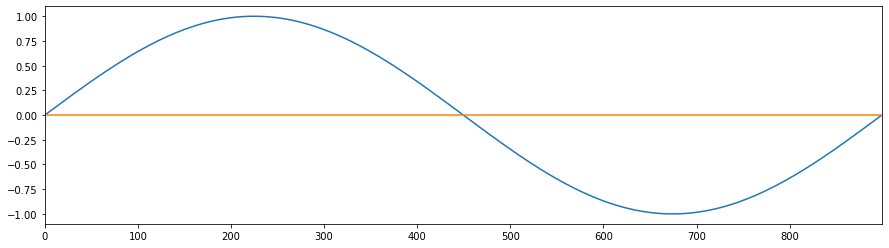

In [17]:
a = np.zeros(899)
import numpy as np
import matplotlib.pyplot as plt

T = 899  # 周期长度
f = 1 / T  # 频率

# x = np.linspace(0, T, 1000)  # 生成1000个在0到T之间的值
x = np.arange(899)
y = np.sin(2 * np.pi * f * x)  # 计算sin函数的值
plt.figure(figsize=(15,4))
plt.plot(x, y)  # 绘制sin函数图形
plt.plot(a)
plt.xlim(0,899)
plt.show()

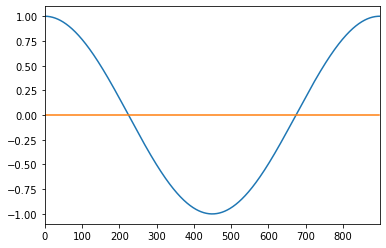

In [18]:
import numpy as np
import matplotlib.pyplot as plt

T =899 # 周期长度
f = 1 / T  # 频率
angle = np.pi / 2  # 角度值，表示相位偏移

# x = np.linspace(0, T, 1000)  # 生成1000个在0到T之间的值
x = np.arange(899)
y1 = np.sin(2 * np.pi * f * x + angle)  # 添加角度值进行相位平移

plt.plot(x, y1)  # 绘制sin函数图形
plt.plot(a)
plt.xlim(0,899)
plt.show()

In [19]:
decode1 = np.tile(y1, (50, 1))
decode0 = np.tile(y, (50, 1))
Decode = np.concatenate((decode0,decode1,decode0), axis=0)#vp4

In [20]:
# 构造全部具有相编码的训练样本
face = np.expand_dims(Decode,2)
Face = np.transpose(face,(1,0,2))
face_t = np.concatenate((S,Face), axis=2)
face_t = np.expand_dims(face_t,2)
Face_t = np.transpose(face_t,(1,0,2,3))

In [21]:
# 构造两道具有相编码的训练样本
face_train = np.stack((Face_t[75,:,:,:],Face_t[125,:,:,:]),axis = 0)

### 相控约束网络及训练

In [22]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Reshape, Multiply, Add, Permute
from tensorflow.keras.models import Model
import numpy as np
from scipy import signal
from pylops.utils.wavelets import ricker

def seismic_loss1(S2_, predictions):
    vsvp = 0.5
    ntheta = 3
    thetamin, thetamax = 10, 30
    theta = np.linspace(thetamin, thetamax, ntheta)

    nt0 = 899
    dt0 = 0.0005
    t0 = np.arange(nt0) * dt0
    ntwav = 401
    wav = np.random.rand(ntwav // 2 + 1).astype(np.float32)

    def reverse(data, Min, Max):
        sample = data * (Max - Min) + Min
        return sample

    Re_FPVP = reverse(predictions[:, :, 0, 0], VPmin125, VPmax125)
    Re_FPVS = reverse(predictions[:, :, 0, 1], VSmin125, VSmax125)
    Re_FPDN = reverse(predictions[:, :, 0, 2], DNmin125, DNmax125)
    Re_FP = tf.stack((Re_FPVP, Re_FPVS, Re_FPDN), axis=2)
    Re_FP1 = tf.expand_dims(Re_FP, axis=2)
    s1 = tf.math.log(Re_FP1)

    SYN = tf.zeros((2, 899, 1, 3), dtype=tf.float32)
    SYN_var = tf.Variable(SYN)

    for i in range(2):
        m = s1[i, :, :, :]
        PPop_dense = pylops.avo.prestack.PrestackLinearModelling(wav, theta, vsvp=vsvp, nt0=nt0, linearization="akirich", explicit=True)
        tf_transposed = tf.transpose(m, perm=[2, 1, 0])
        tf_result = tf.reshape(tf_transposed, [-1])
        dPP_dense = PPop_dense * tf_result
        tf_reshaped = tf.reshape(dPP_dense, [nt0, 1, ntheta])  
        SYN_var[i].assign(tf.cast(tf_reshaped, tf.float32))
    return tf.reduce_mean(tf.square(S2_ - SYN_var)) 

def well_loss2(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

from scipy.signal import butter, filtfilt
def butter_lowpass(nfilt, cutofffr):
    b, a = butter(nfilt, cutofffr, btype='low', analog=False)
    return b, a

def apply_butterworth_filter(y, b, a):
    # Convert b, a to TensorFlow tensors
    b = tf.convert_to_tensor(b, dtype=y.dtype)
    a = tf.convert_to_tensor(a, dtype=y.dtype)

    # Ensure y is 4-dimensional for conv2d
    y = tf.expand_dims(tf.expand_dims(y, axis=-1), axis=0)  # Expand dimensions

    # Forward filtering
    b = tf.reshape(b, (len(b), 1, 1, 1))
    forward = tf.nn.conv2d(y, filters=b, strides=[1, 1, 1, 1], padding='SAME')
    forward /= a[0]

    # Reverse filtering
    backward = tf.nn.conv2d(tf.reverse(forward, axis=[1]), filters=b, strides=[1, 1, 1, 1], padding='SAME')
    backward /= a[0]

    return tf.squeeze(tf.reverse(backward, axis=[1]), axis=0)

def lowmodel_loss3(y_true3, y_pred3):
    # Low-frequency component loss function example (customize as needed)
    y_true3 = tf.expand_dims(y_true3, axis=2)
    y_true3 = tf.transpose(y_true3, (1, 0, 2, 3))

    y_true75 = y_true3[75,:,:,:]
    y_true125 = y_true3[125,:,:,:]
    y_true1 = tf.stack((y_true75,y_true125),axis = 0)

    predictions3 = tf.squeeze(y_pred3)
    predictions_t = y_pred3
    def reverse(data,Min,Max):
        sample = data * (Max- Min) + Min
        return sample
    Re_FPVP = reverse(predictions_t[:,:,0,0],VPmin125,VPmax125)
    Re_FPVS = reverse(predictions_t[:,:,0,1],VSmin125,VSmax125)
    Re_FPDN = reverse(predictions_t[:,:,0,2],DNmin125,DNmax125)
    Re_FP = tf.stack((Re_FPVP,Re_FPVS,Re_FPDN),axis = 2)

    nfilt = 3
    cutofffr = 0.03
    b, a = butter_lowpass(nfilt, cutofffr)

    y_true = y_true1
    y1_pred = tf.expand_dims(Re_FP,axis=2)
    y_pred = y1_pred

    low_freq_true_list = []
    for i in range(y_true.shape[3]):
        for j in range(y_true.shape[2]):
            low_freq_true_list.append(apply_butterworth_filter(y_true[:, :, j, i], b, a))

    low_freq_true = tf.stack(low_freq_true_list, axis=-1)
    low_freq_true1 = tf.reshape(low_freq_true, y_true.shape)

    low_freq_pred_list = []
    for i in range(y_pred.shape[3]):
        for j in range(y_pred.shape[2]):
            low_freq_pred_list.append(apply_butterworth_filter(y_pred[:, :, j, i], b, a))

    low_freq_pred = tf.stack(low_freq_pred_list, axis=-1)
    low_freq_pred1 = tf.reshape(low_freq_pred, y_pred.shape)


    return tf.reduce_mean(tf.square(low_freq_true1-low_freq_pred1))

def face_model_STACGN(input_size=(899,1,4)):
    input_ = Input(input_size)

    conv1 = Conv2D(12, (5,3), padding="same", activation="relu")(input_)
    x = Conv2D(6, (3, 3), activation='relu', padding='same')(conv1)
    a = Dense(6, activation='relu')(x)
    s2 = Multiply()([a, x])

    input_1 = Reshape((899, 4))(input_)
    G1 = tf.keras.layers.GRU(6, return_sequences=True, activation='relu')(input_1)#relu
    g1 = Reshape((899, 1, 6))(G1)
    Gg = Permute((3, 2, 1))(g1)
    G2 = Dense(899, activation='relu')(Gg)
    R = Multiply()([Gg, G2])
    R1 = Permute((3, 2, 1))(R)

    combined = Add()([s2, R1])

    flatten = Flatten()(combined)
    output = Dense(899*3)(flatten)
    output1 = Reshape((899, 1, 3))(output)
    face_model = Model(inputs=input_, outputs=output1)

    return face_model

In [25]:

from tqdm import tqdm
input_size = (899, 1, 4)
face_model = face_model_STACGN(input_size)

# 定义优化器
optimizer = tf.keras.optimizers.Adam()

# 循环次数
num_epochs = 100

# 循环训练
for epoch in tqdm(range(num_epochs)):
    with tf.GradientTape() as tape:
        # 获取模型预测值
        predictions = face_model(face_train, training=True)
        
        # 计算三个损失函数
        loss1 = seismic_loss1(trueseis_2, predictions)
        loss11 = tf.cast(loss1,tf.float32)
        loss2 = well_loss2(Y1_train, predictions)
        loss3 = lowmodel_loss3(Model3, predictions)
        
        total_loss = loss11+loss2+ loss3

    # 计算梯度并更新模型参数
    gradients = tape.gradient(total_loss, face_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, face_model.trainable_variables))

    # 打印每个epoch的损失
    print(f"Epoch {epoch+1}, Total Loss: {total_loss.numpy()}, Loss1: {loss1.numpy()}, Loss2: {loss2.numpy()}, Loss3: {loss3.numpy()}")

# 打印模型摘要
face_model.summary()



  1%|▊                                                                                 | 1/100 [00:03<06:15,  3.79s/it]

Epoch 1, Total Loss: 0.13478770852088928, Loss1: 0.0004740308504551649, Loss2: 0.1343136727809906, Loss3: 2.7089834819804537e-09


  2%|█▋                                                                                | 2/100 [00:07<06:02,  3.70s/it]

Epoch 2, Total Loss: 0.1166134849190712, Loss1: 0.0004275893443264067, Loss2: 0.11618589609861374, Loss3: 2.332850801423092e-09


  3%|██▍                                                                               | 3/100 [00:11<05:54,  3.66s/it]

Epoch 3, Total Loss: 0.09145177900791168, Loss1: 0.0005403519608080387, Loss2: 0.09091142565011978, Loss3: 1.8004592261533503e-09


  4%|███▎                                                                              | 4/100 [00:14<05:57,  3.73s/it]

Epoch 4, Total Loss: 0.05799349769949913, Loss1: 0.0006494531990028918, Loss2: 0.057344045490026474, Loss3: 1.0928830063150485e-09


  5%|████                                                                              | 5/100 [00:18<05:55,  3.74s/it]

Epoch 5, Total Loss: 0.029006803408265114, Loss1: 0.0008592145750299096, Loss2: 0.028147589415311813, Loss3: 4.815553511505755e-10


  6%|████▉                                                                             | 6/100 [00:22<05:52,  3.75s/it]

Epoch 6, Total Loss: 0.02453841082751751, Loss1: 0.0009218587656505406, Loss2: 0.023616552352905273, Loss3: 4.0350361940610924e-10


  7%|█████▋                                                                            | 7/100 [00:26<05:53,  3.80s/it]

Epoch 7, Total Loss: 0.03301792964339256, Loss1: 0.0007087139529176056, Loss2: 0.032309215515851974, Loss3: 6.110032479966776e-10


  8%|██████▌                                                                           | 8/100 [00:30<05:49,  3.79s/it]

Epoch 8, Total Loss: 0.02410089038312435, Loss1: 0.0006561096524819732, Loss2: 0.023444781079888344, Loss3: 4.3979511699099305e-10


  9%|███████▍                                                                          | 9/100 [00:33<05:45,  3.80s/it]

Epoch 9, Total Loss: 0.010815338231623173, Loss1: 0.0006955651915632188, Loss2: 0.01011977344751358, Loss3: 1.7041344724244567e-10


 10%|████████                                                                         | 10/100 [00:37<05:42,  3.81s/it]

Epoch 10, Total Loss: 0.005463579203933477, Loss1: 0.0007985151023603976, Loss2: 0.004665064159780741, Loss3: 6.55537013560803e-11


 11%|████████▉                                                                        | 11/100 [00:41<05:36,  3.78s/it]

Epoch 11, Total Loss: 0.007211258169263601, Loss1: 0.0007858483004383743, Loss2: 0.00642541004344821, Loss3: 1.1156432722092546e-10


 12%|█████████▋                                                                       | 12/100 [00:45<05:30,  3.75s/it]

Epoch 12, Total Loss: 0.010753171518445015, Loss1: 0.0006794485962018371, Loss2: 0.010073723271489143, Loss3: 1.9515784821511062e-10


 13%|██████████▌                                                                      | 13/100 [00:48<05:28,  3.77s/it]

Epoch 13, Total Loss: 0.012707286514341831, Loss1: 0.0007325924234464765, Loss2: 0.011974694207310677, Loss3: 2.398280463111746e-10


 14%|███████████▎                                                                     | 14/100 [00:52<05:25,  3.79s/it]

Epoch 14, Total Loss: 0.011916757561266422, Loss1: 0.0007202578708529472, Loss2: 0.011196499690413475, Loss3: 2.2651838738063645e-10


 15%|████████████▏                                                                    | 15/100 [00:56<05:20,  3.77s/it]

Epoch 15, Total Loss: 0.009141126647591591, Loss1: 0.0006848909542895854, Loss2: 0.008456235751509666, Loss3: 1.7024678888866163e-10


 16%|████████████▉                                                                    | 16/100 [01:00<05:17,  3.78s/it]

Epoch 16, Total Loss: 0.005878513213247061, Loss1: 0.0007098809583112597, Loss2: 0.005168632138520479, Loss3: 1.0028034652664886e-10


 17%|█████████████▊                                                                   | 17/100 [01:04<05:17,  3.82s/it]

Epoch 17, Total Loss: 0.003934567328542471, Loss1: 0.0010347566567361355, Loss2: 0.0028998106718063354, Loss3: 4.947760257056899e-11


 18%|██████████████▌                                                                  | 18/100 [01:08<05:15,  3.85s/it]

Epoch 18, Total Loss: 0.0034122096840292215, Loss1: 0.0008486672304570675, Loss2: 0.002563542453572154, Loss3: 3.8391321371955556e-11


 19%|███████████████▍                                                                 | 19/100 [01:12<05:15,  3.89s/it]

Epoch 19, Total Loss: 0.004485937766730785, Loss1: 0.0008096726960502565, Loss2: 0.0036762652453035116, Loss3: 5.965885424563666e-11


 20%|████████████████▏                                                                | 20/100 [01:16<05:21,  4.02s/it]

Epoch 20, Total Loss: 0.005420057103037834, Loss1: 0.0008608915377408266, Loss2: 0.004559165332466364, Loss3: 8.00302255021812e-11


 21%|█████████████████                                                                | 21/100 [01:20<05:25,  4.12s/it]

Epoch 21, Total Loss: 0.004693283699452877, Loss1: 0.0006900995504111052, Loss2: 0.004003183916211128, Loss3: 7.308571803310571e-11


 22%|█████████████████▊                                                               | 22/100 [01:25<05:24,  4.16s/it]

Epoch 22, Total Loss: 0.0031651209574192762, Loss1: 0.0007416825392283499, Loss2: 0.0024234384763985872, Loss3: 4.459495966946392e-11


 23%|██████████████████▋                                                              | 23/100 [01:29<05:20,  4.17s/it]

Epoch 23, Total Loss: 0.0016797941643744707, Loss1: 0.0005932309431955218, Loss2: 0.0010865632211789489, Loss3: 1.89555524054974e-11


 24%|███████████████████▍                                                             | 24/100 [01:34<05:39,  4.47s/it]

Epoch 24, Total Loss: 0.0014335339656099677, Loss1: 0.0006636994075961411, Loss2: 0.0007698345580138266, Loss3: 1.2337665611372728e-11


 25%|████████████████████▎                                                            | 25/100 [01:39<05:38,  4.52s/it]

Epoch 25, Total Loss: 0.0018684889655560255, Loss1: 0.0005868650041520596, Loss2: 0.001281623961403966, Loss3: 2.1963377297429254e-11


 26%|█████████████████████                                                            | 26/100 [01:43<05:30,  4.46s/it]

Epoch 26, Total Loss: 0.0025035266298800707, Loss1: 0.0005942774587310851, Loss2: 0.0019092492293566465, Loss3: 3.425847799887194e-11


 27%|█████████████████████▊                                                           | 27/100 [01:48<05:47,  4.76s/it]

Epoch 27, Total Loss: 0.002616587560623884, Loss1: 0.0005431108293123543, Loss2: 0.002073476789519191, Loss3: 3.7777475592193355e-11


 28%|██████████████████████▋                                                          | 28/100 [01:54<05:53,  4.91s/it]

Epoch 28, Total Loss: 0.002235802821815014, Loss1: 0.00056058494374156, Loss2: 0.001675217878073454, Loss3: 3.039681353844692e-11


 29%|███████████████████████▍                                                         | 29/100 [01:58<05:37,  4.76s/it]

Epoch 29, Total Loss: 0.0015825164737179875, Loss1: 0.0005391712766140699, Loss2: 0.0010433451971039176, Loss3: 1.8380670249729114e-11


 30%|████████████████████████▎                                                        | 30/100 [02:03<05:28,  4.69s/it]

Epoch 30, Total Loss: 0.0011572057846933603, Loss1: 0.0005165389156900346, Loss2: 0.0006406668690033257, Loss3: 1.0690520517442348e-11


 31%|█████████████████████████                                                        | 31/100 [02:07<05:24,  4.71s/it]

Epoch 31, Total Loss: 0.0012554061831906438, Loss1: 0.0005531366332434118, Loss2: 0.000702269549947232, Loss3: 1.1857426499006785e-11


 32%|█████████████████████████▉                                                       | 32/100 [02:12<05:14,  4.63s/it]

Epoch 32, Total Loss: 0.0016747157787904143, Loss1: 0.0006336614023894072, Loss2: 0.0010410543764010072, Loss3: 1.8198742859909522e-11


 33%|██████████████████████████▋                                                      | 33/100 [02:17<05:24,  4.85s/it]

Epoch 33, Total Loss: 0.0018977121217176318, Loss1: 0.0006695777410641313, Loss2: 0.0012281343806535006, Loss3: 2.1464307761731583e-11


 34%|███████████████████████████▌                                                     | 34/100 [02:22<05:24,  4.92s/it]

Epoch 34, Total Loss: 0.0016319501446560025, Loss1: 0.0006075554993003607, Loss2: 0.0010243946453556418, Loss3: 1.7263506596476574e-11


 35%|████████████████████████████▎                                                    | 35/100 [02:27<05:20,  4.94s/it]

Epoch 35, Total Loss: 0.0012540868483483791, Loss1: 0.0006653307355009019, Loss2: 0.0005887561128474772, Loss3: 8.999511205698418e-12


 36%|█████████████████████████████▏                                                   | 36/100 [02:32<05:23,  5.06s/it]

Epoch 36, Total Loss: 0.0008167244959622622, Loss1: 0.0005504455766640604, Loss2: 0.00026627894840203226, Loss3: 3.4249885913495426e-12


 37%|█████████████████████████████▉                                                   | 37/100 [02:38<05:27,  5.19s/it]

Epoch 37, Total Loss: 0.0007704992895014584, Loss1: 0.0005325331003405154, Loss2: 0.00023796620371285826, Loss3: 3.7499742894242516e-12


 38%|██████████████████████████████▊                                                  | 38/100 [02:43<05:19,  5.16s/it]

Epoch 38, Total Loss: 0.0011017287615686655, Loss1: 0.0006959317252039909, Loss2: 0.0004057970945723355, Loss3: 7.680656458064483e-12


 39%|███████████████████████████████▌                                                 | 39/100 [02:48<05:02,  4.96s/it]

Epoch 39, Total Loss: 0.00107597338501364, Loss1: 0.0005347064579837024, Loss2: 0.0005412669270299375, Loss3: 1.0523804050421859e-11


 40%|████████████████████████████████▍                                                | 40/100 [02:53<05:07,  5.12s/it]

Epoch 40, Total Loss: 0.0010155655909329653, Loss1: 0.0005099793779663742, Loss2: 0.0005055861547589302, Loss3: 9.60969151475588e-12


 41%|█████████████████████████████████▏                                               | 41/100 [02:58<04:58,  5.06s/it]

Epoch 41, Total Loss: 0.0008969121845439076, Loss1: 0.0005548283224925399, Loss2: 0.00034208386205136776, Loss3: 6.0499365933663896e-12


 42%|██████████████████████████████████                                               | 42/100 [03:02<04:43,  4.89s/it]

Epoch 42, Total Loss: 0.0007773558609187603, Loss1: 0.0005739514017477632, Loss2: 0.00020340445917099714, Loss3: 3.1413764818577494e-12


 43%|██████████████████████████████████▊                                              | 43/100 [03:07<04:25,  4.66s/it]

Epoch 43, Total Loss: 0.0008159329299814999, Loss1: 0.0006175755406729877, Loss2: 0.0001983573893085122, Loss3: 3.171219146655413e-12


 44%|███████████████████████████████████▋                                             | 44/100 [03:11<04:11,  4.50s/it]

Epoch 44, Total Loss: 0.000849155941978097, Loss1: 0.0005552982911467552, Loss2: 0.0002938576217275113, Loss3: 5.3795535734368904e-12


 45%|████████████████████████████████████▍                                            | 45/100 [03:15<04:09,  4.54s/it]

Epoch 45, Total Loss: 0.001008882885798812, Loss1: 0.0006501544849015772, Loss2: 0.0003587283717934042, Loss3: 6.92724697048952e-12


 46%|█████████████████████████████████████▎                                           | 46/100 [03:20<04:05,  4.55s/it]

Epoch 46, Total Loss: 0.0009795433143153787, Loss1: 0.0006748146843165159, Loss2: 0.0003047286591026932, Loss3: 5.914834160652971e-12


 47%|██████████████████████████████████████                                           | 47/100 [03:25<04:17,  4.86s/it]

Epoch 47, Total Loss: 0.0007546350825577974, Loss1: 0.0005813323659822345, Loss2: 0.00017330270202364773, Loss3: 3.210933905914426e-12


 48%|██████████████████████████████████████▉                                          | 48/100 [03:31<04:16,  4.93s/it]

Epoch 48, Total Loss: 0.0006109466776251793, Loss1: 0.0005347692058421671, Loss2: 7.617750088684261e-05, Loss3: 1.1899226179043487e-12


 49%|███████████████████████████████████████▋                                         | 49/100 [03:35<04:03,  4.77s/it]

Epoch 49, Total Loss: 0.0006370363989844918, Loss1: 0.0005621262243948877, Loss2: 7.491019641747698e-05, Loss3: 1.1793142417476643e-12


 50%|████████████████████████████████████████▌                                        | 50/100 [03:39<03:53,  4.67s/it]

Epoch 50, Total Loss: 0.0006846134783700109, Loss1: 0.0005517106037586927, Loss2: 0.00013290290371514857, Loss3: 2.4323301619361137e-12


 51%|█████████████████████████████████████████▎                                       | 51/100 [03:44<03:46,  4.63s/it]

Epoch 51, Total Loss: 0.0007173118647187948, Loss1: 0.0005472742486745119, Loss2: 0.00017003764514811337, Loss3: 3.2633778491997223e-12


 52%|██████████████████████████████████████████                                       | 52/100 [03:48<03:33,  4.44s/it]

Epoch 52, Total Loss: 0.0006508398801088333, Loss1: 0.0005053738132119179, Loss2: 0.0001454660523450002, Loss3: 2.7896769096147356e-12


 53%|██████████████████████████████████████████▉                                      | 53/100 [03:52<03:26,  4.39s/it]

Epoch 53, Total Loss: 0.0007274799863807857, Loss1: 0.0006400690181180835, Loss2: 8.741097553865984e-05, Loss3: 1.5779549975697416e-12


 54%|███████████████████████████████████████████▋                                     | 54/100 [03:56<03:19,  4.34s/it]

Epoch 54, Total Loss: 0.0006566253141500056, Loss1: 0.000603520660661161, Loss2: 5.3104628022992983e-05, Loss3: 8.302144236839448e-13


 55%|████████████████████████████████████████████▌                                    | 55/100 [04:01<03:16,  4.36s/it]

Epoch 55, Total Loss: 0.0007699873531237245, Loss1: 0.000703421188518405, Loss2: 6.656613550148904e-05, Loss3: 1.0844534905490866e-12


 56%|█████████████████████████████████████████████▎                                   | 56/100 [04:05<03:14,  4.41s/it]

Epoch 56, Total Loss: 0.000640036363620311, Loss1: 0.0005422384710982442, Loss2: 9.779789252206683e-05, Loss3: 1.7505358057209874e-12


 57%|██████████████████████████████████████████████▏                                  | 57/100 [04:10<03:18,  4.61s/it]

Epoch 57, Total Loss: 0.0007659994880668819, Loss1: 0.0006640779320150614, Loss2: 0.00010192157787969336, Loss3: 1.8920357901935914e-12


 58%|██████████████████████████████████████████████▉                                  | 58/100 [04:15<03:13,  4.61s/it]

Epoch 58, Total Loss: 0.0006201672949828207, Loss1: 0.0005497505189850926, Loss2: 7.041677599772811e-05, Loss3: 1.292970396547799e-12


 59%|███████████████████████████████████████████████▊                                 | 59/100 [04:20<03:16,  4.79s/it]

Epoch 59, Total Loss: 0.0006197853363119066, Loss1: 0.0005844017141498625, Loss2: 3.538363671395928e-05, Loss3: 5.827911937761332e-13


 60%|████████████████████████████████████████████████▌                                | 60/100 [04:25<03:07,  4.70s/it]

Epoch 60, Total Loss: 0.0007172215264290571, Loss1: 0.0006891645025461912, Loss2: 2.8057034796802327e-05, Loss3: 4.0897420541287366e-13


 61%|█████████████████████████████████████████████████▍                               | 61/100 [04:29<03:02,  4.67s/it]

Epoch 61, Total Loss: 0.0005415313062258065, Loss1: 0.0004963225801475346, Loss2: 4.520874790614471e-05, Loss3: 7.383957269409269e-13


 62%|██████████████████████████████████████████████████▏                              | 62/100 [04:34<02:58,  4.70s/it]

Epoch 62, Total Loss: 0.0005782112129963934, Loss1: 0.0005195169942453504, Loss2: 5.8694200561149046e-05, Loss3: 1.0230862381235828e-12


 63%|███████████████████████████████████████████████████                              | 63/100 [04:39<03:00,  4.88s/it]

Epoch 63, Total Loss: 0.0006300895474851131, Loss1: 0.0005803322419524193, Loss2: 4.9757301894715056e-05, Loss3: 8.806019064985793e-13


 64%|███████████████████████████████████████████████████▊                             | 64/100 [04:44<02:49,  4.71s/it]

Epoch 64, Total Loss: 0.0005383031675592065, Loss1: 0.0005109204794280231, Loss2: 2.7382693588151596e-05, Loss3: 4.713491966526484e-13


 65%|████████████████████████████████████████████████████▋                            | 65/100 [04:48<02:41,  4.63s/it]

Epoch 65, Total Loss: 0.0005606060731224716, Loss1: 0.0005463771522045135, Loss2: 1.422890454705339e-05, Loss3: 2.3145870528366863e-13


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [04:52<02:32,  4.48s/it]

Epoch 66, Total Loss: 0.0006351873162202537, Loss1: 0.0006154038710519671, Loss2: 1.978345426323358e-05, Loss3: 3.4514372696664575e-13


 67%|██████████████████████████████████████████████████████▎                          | 67/100 [04:56<02:22,  4.33s/it]

Epoch 67, Total Loss: 0.0005359819624572992, Loss1: 0.0005043183919042349, Loss2: 3.1663548725191504e-05, Loss3: 5.723191018325302e-13


 68%|███████████████████████████████████████████████████████                          | 68/100 [05:00<02:14,  4.20s/it]

Epoch 68, Total Loss: 0.0005390605074353516, Loss1: 0.000506291282363236, Loss2: 3.276922507211566e-05, Loss3: 5.85911744468981e-13


 69%|███████████████████████████████████████████████████████▉                         | 69/100 [05:04<02:07,  4.13s/it]

Epoch 69, Total Loss: 0.000565915834158659, Loss1: 0.0005444618291221559, Loss2: 2.1454023226397112e-05, Loss3: 3.649129880645835e-13


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [05:08<02:03,  4.11s/it]

Epoch 70, Total Loss: 0.0005439373198896646, Loss1: 0.0005332378204911947, Loss2: 1.0699477570597082e-05, Loss3: 1.6923204645361706e-13


 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [05:13<02:01,  4.19s/it]

Epoch 71, Total Loss: 0.0007028286345303059, Loss1: 0.000692306668497622, Loss2: 1.0521972399146762e-05, Loss3: 1.8792798805837563e-13


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [05:17<01:55,  4.14s/it]

Epoch 72, Total Loss: 0.000745893397834152, Loss1: 0.0007288510096259415, Loss2: 1.7042370018316433e-05, Loss3: 3.3009364555983134e-13


 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [05:21<01:52,  4.15s/it]

Epoch 73, Total Loss: 0.0005701676127500832, Loss1: 0.0005505928420461714, Loss2: 1.9574763427954167e-05, Loss3: 3.775570080102181e-13


 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [05:25<01:49,  4.22s/it]

Epoch 74, Total Loss: 0.0005738088511861861, Loss1: 0.0005596055998466909, Loss2: 1.4203237697074655e-05, Loss3: 2.5916741626039186e-13


 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [05:30<01:48,  4.33s/it]

Epoch 75, Total Loss: 0.0006411740323528647, Loss1: 0.0006340239779092371, Loss2: 7.150070359784877e-06, Loss3: 1.1080328684741e-13


 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [05:37<02:03,  5.13s/it]

Epoch 76, Total Loss: 0.0005461998516693711, Loss1: 0.0005404298426583409, Loss2: 5.769990821136162e-06, Loss3: 8.505469142579616e-14


 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [05:43<02:02,  5.34s/it]

Epoch 77, Total Loss: 0.0005689852405339479, Loss1: 0.0005594296962954104, Loss2: 9.555525139148813e-06, Loss3: 1.67946507937701e-13


 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [05:47<01:53,  5.18s/it]

Epoch 78, Total Loss: 0.0004981427337042987, Loss1: 0.0004862362111452967, Loss2: 1.1906499821634497e-05, Loss3: 2.2032665947767371e-13


 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [05:52<01:47,  5.10s/it]

Epoch 79, Total Loss: 0.0005624403711408377, Loss1: 0.0005533309886232018, Loss2: 9.109408892982174e-06, Loss3: 1.6560110758807173e-13


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [05:57<01:40,  5.04s/it]

Epoch 80, Total Loss: 0.000543872534763068, Loss1: 0.0005394127801991999, Loss2: 4.4597559281100985e-06, Loss3: 7.345490047380027e-14


 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [06:02<01:32,  4.88s/it]

Epoch 81, Total Loss: 0.0006003720918670297, Loss1: 0.0005972902290523052, Loss2: 3.0818550840194803e-06, Loss3: 5.026494086408928e-14


 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [06:06<01:26,  4.83s/it]

Epoch 82, Total Loss: 0.0005420313682407141, Loss1: 0.0005367033882066607, Loss2: 5.327983672032133e-06, Loss3: 1.0191109430955289e-13


 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [06:11<01:21,  4.80s/it]

Epoch 83, Total Loss: 0.0006024616304785013, Loss1: 0.0005953104118816555, Loss2: 7.151212230382953e-06, Loss3: 1.427511808847065e-13


 84%|████████████████████████████████████████████████████████████████████             | 84/100 [06:16<01:15,  4.73s/it]

Epoch 84, Total Loss: 0.0004892329452559352, Loss1: 0.00048343720845878124, Loss2: 5.795744527858915e-06, Loss3: 1.1498370615023457e-13


 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [06:20<01:09,  4.66s/it]

Epoch 85, Total Loss: 0.000609841023106128, Loss1: 0.000606910209171474, Loss2: 2.9308200737432344e-06, Loss3: 5.4168417662611365e-14


 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [06:25<01:05,  4.71s/it]

Epoch 86, Total Loss: 0.0004997394280508161, Loss1: 0.0004979222430847585, Loss2: 1.8171684814660694e-06, Loss3: 2.9809728768542473e-14


 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [06:30<01:01,  4.69s/it]

Epoch 87, Total Loss: 0.0005339812487363815, Loss1: 0.0005310034612193704, Loss2: 2.9777988856949378e-06, Loss3: 5.409607427265227e-14


 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [06:35<00:57,  4.78s/it]

Epoch 88, Total Loss: 0.0005842560203745961, Loss1: 0.0005802294472232461, Loss2: 4.0265967982122675e-06, Loss3: 7.71452536183978e-14


 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [06:40<00:52,  4.79s/it]

Epoch 89, Total Loss: 0.000492049497552216, Loss1: 0.0004888213006779552, Loss2: 3.228188461434911e-06, Loss3: 6.122228781877889e-14


 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [06:44<00:46,  4.60s/it]

Epoch 90, Total Loss: 0.0005439926753751934, Loss1: 0.000542374444194138, Loss2: 1.6182028730327147e-06, Loss3: 2.658423238759578e-14


 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [06:48<00:41,  4.63s/it]

Epoch 91, Total Loss: 0.0005825627595186234, Loss1: 0.0005814014584757388, Loss2: 1.1612926300585968e-06, Loss3: 1.475435509987362e-14


 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [06:53<00:36,  4.60s/it]

Epoch 92, Total Loss: 0.000574859615880996, Loss1: 0.0005728481337428093, Loss2: 2.0115060124226147e-06, Loss3: 3.1104577870614755e-14


 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [06:57<00:30,  4.42s/it]

Epoch 93, Total Loss: 0.0005830678273923695, Loss1: 0.0005804592510685325, Loss2: 2.608547674753936e-06, Loss3: 4.4682804006303256e-14


 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [07:01<00:26,  4.34s/it]

Epoch 94, Total Loss: 0.0005751674179919064, Loss1: 0.0005731675191782415, Loss2: 1.999924961637589e-06, Loss3: 3.4939878681278236e-14


 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [07:05<00:21,  4.24s/it]

Epoch 95, Total Loss: 0.0005957321263849735, Loss1: 0.0005947475438006222, Loss2: 9.845555268839234e-07, Loss3: 1.6287113733973006e-14


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [07:09<00:16,  4.24s/it]

Epoch 96, Total Loss: 0.0006147152162156999, Loss1: 0.0006139448378235102, Loss2: 7.703896471866756e-07, Loss3: 1.2425058540637551e-14


 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [07:13<00:12,  4.21s/it]

Epoch 97, Total Loss: 0.000583302229642868, Loss1: 0.0005819947691634297, Loss2: 1.3074375146970851e-06, Loss3: 2.2924013287129764e-14


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [07:17<00:08,  4.13s/it]

Epoch 98, Total Loss: 0.0006852293736301363, Loss1: 0.0006836688844487071, Loss2: 1.5604705367877614e-06, Loss3: 2.7900182774450062e-14


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [07:22<00:04,  4.17s/it]

Epoch 99, Total Loss: 0.0006714484770782292, Loss1: 0.0006703868857584894, Loss2: 1.061594844031788e-06, Loss3: 1.839106903605333e-14


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [07:26<00:00,  4.46s/it]

Epoch 100, Total Loss: 0.0006489516817964613, Loss1: 0.000648503249976784, Loss2: 4.484569444684894e-07, Loss3: 6.922256906273733e-15
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 899, 1, 4)]  0                                            
__________________________________________________________________________________________________
reshape_6 (Reshape)             (None, 899, 4)       0           input_3[0][0]                    
__________________________________________________________________________________________________
gru_2 (GRU)                     (None, 899, 6)       216         reshape_6[0][0]                  
__________________________________________________________________________________________________
reshape_7 (Reshape)             (None, 899, 1, 6)    0   

In [26]:
face_pred = face_model(Face_t, training=True)
face_pred_np = np.array(face_pred)

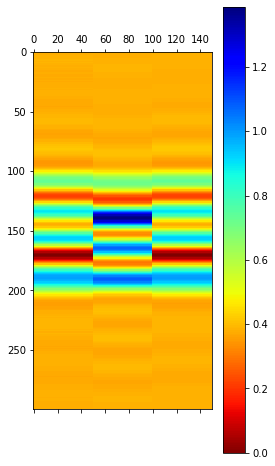

In [27]:
e=300
f=600
plt.matshow(face_pred_np[:,e:f,0,0].T,cmap = 'jet_r')
plt.colorbar()

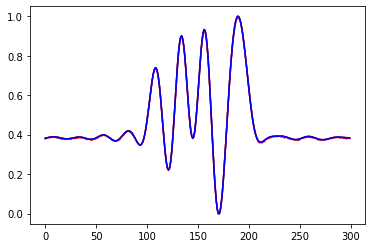

In [28]:
plt.plot(Y1_train[1,e:f,0,0],'k')
plt.plot(face_pred_np[25,e:f,0,0],'r')
plt.plot(face_pred_np[125,e:f,0,0],'b')

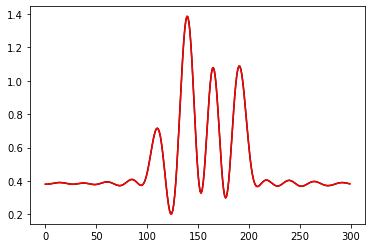

In [29]:
plt.plot(Y1_train[0,e:f,0,0],'k')
plt.plot(face_pred_np[75,e:f,0,0],'r')

### 对预测值进行反归一化

In [30]:
def reverse(data,Min,Max):
    sample = data * (Max- Min) + Min
    return sample

In [32]:
face_pred_vp = reverse(face_pred_np[:,:,0,0],VPmin125,VPmax125)
face_pred_vs = reverse(face_pred_np[:,:,0,1],VSmin125,VSmax125)
face_pred_den = reverse(face_pred_np[:,:,0,2],DNmin125,DNmax125)
Re_face_pred = np.stack((face_pred_vp,face_pred_vs,face_pred_den),axis = 2)
Re_face_pred.shape

(150, 899, 3)

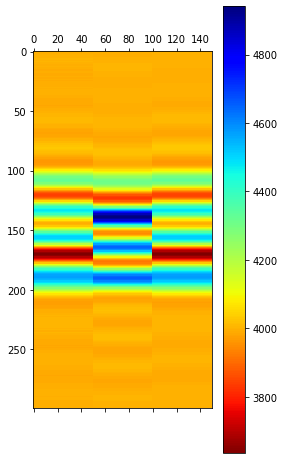

In [33]:
e=300
f=600
plt.matshow(Re_face_pred[:,e:f,0].T,cmap = 'jet_r')
plt.colorbar()

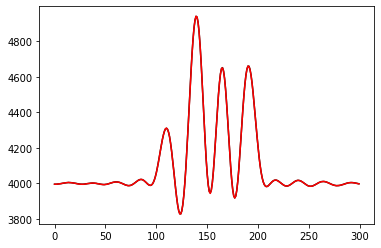

In [39]:
e=300
f=600
plt.plot(Model3[300:600,75,0],'k')
plt.plot(Re_face_pred[75,e:f,0],'r')

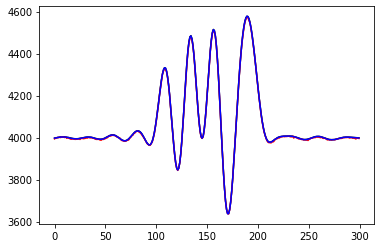

In [40]:
e=300
f=600
plt.plot(Model3[300:600,125,0],'k')
plt.plot(Re_face_pred[25,e:f,0],'r')
plt.plot(Re_face_pred[125,e:f,0],'b')